In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geopandas.org/_images/overlay_operations.png")

# Visualization of spatial data using PolygonPatch

In [ ]:
import matplotlib.pyplot as plt

def add_geometry(data, ax, geometry = 'polygon', fc = '#cccccc', ec='k'):
    
    if geometry == 'polygon':
        for polygon in data:
            patch = PolygonPatch(polygon, fc=fc, ec=ec, alpha=0.5, zorder=2)
            ax.add_patch(patch)
            
    elif geometry == 'point':
        ax.scatter(x=data['x'], y=data['y'], s=1, c=fc, linewidth=0, zorder=1)
        

# Spatial Join on CPU and GPU without indexing and splitting

In [ ]:
import time
import geopandas as gpd
from numba.extending import overload
import matplotlib.pyplot as plt

def sjoin_without_indexing(data_1, data_2, device = 'CPU', plot = False):
    start_time = time.time()
    join_result = gpd.sjoin(data_1, data_2, how="inner", op='intersects')
    end_time = time.time()
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))

@overload(sjoin_without_indexing)
def gpu_sjoin_without_indexing(data1, data2, plot = True):
    sjoin_without_indexing(data1, data2, device = 'GPU', plot = plot)

In [ ]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
import osmnx as ox

data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_2 = gpd.read_file("Point_dataset/LA_point_dataset.shp") # Point

gpu_sjoin_without_indexing(data_1, data_2, plot = False)

# Spatial Join on CPU and GPU with indexing and without splitting

In [ ]:
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload

import matplotlib.pyplot as plt
import time

def sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_1 = data_1['geometry'].iloc[0]
    if isinstance(geometry_1, Polygon):
        geometry_1 = MultiPolygon([geometry_1])
        
    start_time = time.time()
#     indexing data_2 - point dataset
    sindex_2 = data_2.sindex
    
#     filter phase
    possible_indices = list(sindex_2.intersection(geometry_1.bounds))
    possible_matches = data_2.iloc[possible_indices]
    
#     refinement phase
    precise_matches = possible_matches[possible_matches.intersects(geometry_1)]
    # cannot use index structure of data 2 for intersects operation, accepts Series datatype only     
    end_time = time.time()
    
#     plotting the sjoin results 
    points_within_geometry = precise_matches
    points_outside_geometry = data_2[~data_2.isin(points_within_geometry)]
    
    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
            
        add_geometry(geometry_1, ax, geometry = 'polygon', fc = '#cccccc', ec='k')
        add_geometry(points_outside_geometry, ax, geometry = 'point', fc = 'r')
        add_geometry(points_within_geometry, ax, geometry = 'point', fc = 'b')

        ax.axis('off')
        plt.show()
    
    print("S-join without splitting on {0} = {1}".format(device, end_time - start_time))
    
@overload(sjoin_with_indexing)
def gpu_sjoin_with_indexing(data_1, data_2, device = 'CPU', plot = True):
    sjoin_with_indexing(data_1, data_2, device = 'GPU', plot = True)    

import osmnx as ox
data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_2 = gpd.read_file("Point_dataset/LA_point_dataset.shp") # Point

gpu_sjoin_with_indexing(data_1, data_2)

# Spatial Join on CPU and GPU with indexing and splitting

In [ ]:
from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox
import geopandas as gpd

def get_point_dataset(location = 'Los Angeles, California, USA', data = gpd.GeoDataFrame()):
    
    print('Getting point datasets..')
    if data.empty:  
        data = ox.geocode_to_gdf(location)        
    west, south, east, north = data.unary_union.bounds
    
    G = ox.graph_from_bbox(north, south, east, west, network_type='all', retain_all=True)
    xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
    x, y = list(zip(*xy))
    # x - list of all x-coordinates
    # y - list of all y-coordinates

    points = gpd.GeoDataFrame(data={'x':x, 'y':y})
    points['geometry'] = points.apply(lambda row: Point((row['x'], row['y'])), axis=1)
    points.crs = data.crs
    points.name = 'nodes'
    
    return gdf_nodes

In [ ]:
import osmnx as ox
data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_2 = get_point_dataset(data = data_1) # Point

In [ ]:
data_2.to_file("./Point_dataset/LA_point_dataset.shp")

In [ ]:
import osmnx as ox
data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_2 = gpd.read_file("Point_dataset/LA_point_dataset.shp") # Point

In [ ]:
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

from numba.extending import overload
from numba import jit

import matplotlib.pyplot as plt
import time

@jit
def sjoin_with_splitting(data_1, data_2, device = 'CPU', plot = True):
    
#     convert input data to Multipolygon as needed by sjoin
    geometry_1 = data_1['geometry'].iloc[0]
    if isinstance(geometry_1, Polygon):
        geometry_1 = MultiPolygon([geometry_1])
        
    start_time = time.time()
    
#     Splitting polygon data into squares of width 0.1
    geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry_1, quadrat_width=0.1)
#     indexing data_2
    sindex_2 = data_2.sindex
       
    points_within_geometry = pd.DataFrame()
    for sub_poly in geometry_cut:        
        # filter phase 
#         sub_poly = sub_poly.buffer(1e-14).buffer(0)
#         possible_indices = list(sindex_2.intersection(sub_poly.bounds))
#         possible_matches = data_2.iloc[possible_indices]
        
        # refinement phase
        precise_matches = data_2[data_2.intersects(sub_poly)]
        points_within_geometry = points_within_geometry.append(precise_matches)
        
#     remove duplicate matches
    points_within_geometry = points_within_geometry.drop_duplicates(subset=['x', 'y'])
    end_time = time.time()
    points_outside_geometry = data_2[~data_2.isin(points_within_geometry)]   
    
#     plotting the sjoin results     
    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
            
        add_geometry(geometry_1, ax, geometry = 'polygon', fc = '#cccccc', ec='k')
        add_geometry(points_outside_geometry, ax, geometry = 'point', fc = 'r')
        add_geometry(points_within_geometry, ax, geometry = 'point', fc = 'b')

        ax.axis('off')
        plt.show()
    
    print("S-join with splitting on {0} = {1}".format(device, end_time - start_time))
    
@overload(sjoin_with_splitting)
def gpu_sjoin_with_splitting(data_1, data_2, device = 'CPU', plot = True):
    sjoin_with_splitting(data_1, data_2, device = 'GPU', plot = True)

sjoin_with_splitting(data_1, data_2)

In [ ]:
data = ox.geocode_to_gdf('Los Angeles, California, USA')
west, south, east, north = data.unary_union.bounds
print(west, south, east, north)
G = ox.graph_from_bbox(north, south, east, west, network_type='all', retain_all=True)

In [ ]:
from shapely.geometry import Point, Polygon, MultiPolygon
xy = [(data['x'], data['y']) for node, data in G.nodes(data=True)]
x, y = list(zip(*xy))
# x - list of all x-coordinates
# y - list of all y-coordinates

gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y})
print(gdf_nodes)
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1)
gdf_nodes.crs = data.crs
gdf_nodes.name = 'nodes'

In [ ]:
gdf_nodes.plot()

In [ ]:
print(x[1:10], y[1:10])
print(xy[1:10])

In [ ]:
print(data_2.iloc[0])
print()
print('Shape: ', data_2.shape)
print()
print('Datatype of geometry: ', type(data_2['geometry']))
print()
print('Area: ', data_2['geometry'].area)
print()
print('Data bounds:\n', data_2['geometry'].bounds)
print()
print('Geometry: ', data_2['geometry'].geom_type)

In [ ]:
# sjoin_with_indexing(gdb_data, data_3, plot = False)

# gpu_sjoin_with_indexing(gdb_data, data_3)

# Output isn't correct

# Convert wkt to GeodataFrames

In [ ]:
from shapely import wkt

wkt_csv_data = pd.read_csv("Datasets/wkt_format/primaryroads_wkt.csv")
wkt_csv_data = wkt_csv_data[].apply(wkt.loads)

wkt_gdf_data = gpd.GeoDataFrame(wkt_csv_data)

wkt_gdf_data.plot(ec = "#0b1878", figsize=(24,24))

         minx       miny       maxx       maxy
0 -118.951722  32.796929 -117.64627  34.823312


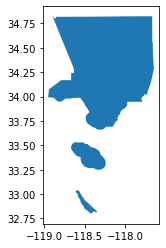

In [4]:
import osmnx as ox
data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_1.plot()
print(data_1.bounds)

         minx       miny       maxx       maxy
0 -118.951722  32.796929 -117.64627  34.823312


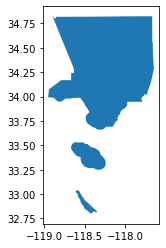

In [5]:
import osmnx as ox
data_1 = ox.geocode_to_gdf('Los Angeles, California, USA') # Multipolygon
data_1.plot()
print(data_1.bounds)